In [73]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

# sns.set(font_scale=1.2)
# Function `set` is deprecated in favor of `set_theme`
# https://seaborn.pydata.org/generated/seaborn.set_theme.html

print('Automobilių kainos vertinimas.\nTrečioji projekto versija.')

# Šis failas:
# /home/administratorius/git/python_kursai/DataScienceNotebooks/Studentai/MykolasOK/2024-11-13_autop.ipynb
# Duomenų šaltiniai:
# /home/administratorius/git/python_kursai/DataScienceNotebooks/DATA/atlyginimai.csv (-)
# /home/administratorius/git/python_kursai/DataScienceNotebooks/DATA/WEBscr.db (+)

print("Automobilių duomenys paimami iš DB failo")
conn = sqlite3.connect('../../DATA/WEBscr.db')
# query = "SELECT name FROM sqlite_master WHERE type='table';"
# print(pd.read_sql_query(query, conn)['name'].tolist())
query = '''SELECT TAutos.*, TUrl.url, TUrl.name, TUrl.params
            FROM TAutos
            LEFT JOIN TUrl ON TAutos.id = TUrl.id
            GROUP BY TAutos.id;'''
df=pd.read_sql_query(query, conn) # Kuriamas df.
# print(df.columns,end='\n')

print('Paimta įrašų:',len(df))

Automobilių kainos vertinimas.
Trečioji projekto versija.
Automobilių duomenys paimami iš DB failo
Paimta įrašų: 35913


In [74]:
# import pandas as pd
import re
from datetime import datetime

def extract_year_int(date_str):
    if not date_str:
        return None  # Grąžiname None, jei eilutė tuščia ar None

    # Reguliarioji išraiška, ieškanti metų ISO formato datos dalyje (YYYY-MM-DD arba YYYY-MM)
    match = re.search(r'\b(\d{4})\b', date_str)

    if match:
        year = int(match.group(1))
    
        # Patikriname, ar metai atitinka protingą intervalą (pvz., nuo 1000 iki dabartinių metų)
        current_year = datetime.now().year
        if 1900 < year < current_year+4:
            return year

    return None  # Grąžiname None, jei metų rasti nepavyko

print(extract_year_int("2023-06-12"))  # rezultatas: 2023
# print(extract_year_int("1999-12-12"))  # rezultatas: 1999
# print(extract_year_int("2020-07"))     # rezultatas: 2020
# print(extract_year_int("2020-24"))     # rezultatas: 2020
# print(extract_year_int("1999"))        # rezultatas: 1999
# print(extract_year_int("1999-12"))     # rezultatas: 1999
# print(extract_year_int("nėra datos"))  # rezultatas: None
# print(extract_year_int(""))            # rezultatas: None
# print(extract_year_int("9999-12-31"))  # rezultatas: None

2023


In [75]:
import pandas as pd
import numpy as np

def extract_year_float( date_str:str, default_month:int=0 ):
    """
    Funkcija, kuri iš ISO datos ištraukia metus ir mėnesį bei grąžina metus kaip float.
    
    :param date_str: (str) ISO formato data arba dalinė data.
    :param default_month: (int) Mėnesio reikšmė, kuri naudojama, jei mėnuo nenurodytas.
    :return: (float) Metai + mėnuo / 12 arba NaN, jei metai nenurodyti.
    """
    try:
        if default_month > 12:
            default_month = 0

        # Bandome pilną datą (%Y-%m-%d)
        parsed_date = pd.to_datetime(date_str, format='%Y-%m-%d', errors='coerce')
        
        if pd.isna(parsed_date):
            # Jei pilna data nepavyko, bandome tik metus ir mėnesį (%Y-%m)
            parsed_date = pd.to_datetime(date_str, format='%Y-%m', errors='coerce')
            
        if pd.isna(parsed_date):
            # Jei nepavyko nei vienas formatas, bandome tik metus (%Y)
            year_only = pd.to_datetime(date_str, format='%Y', errors='coerce')
            if pd.isna(year_only):
                return np.nan  # Jei metai nenurodyti, grąžiname NaN
            else:
                # Metai nurodyti, mėnuo nenurodytas
                return float(year_only.year + default_month/12 - (1/24 if default_month > 0 else 0))
            
        # Jei sėkmingai išanalizuota data (pilna arba tik metai ir mėnuo)
        year = parsed_date.year
        month = parsed_date.month
        return float(year + month/12 - (1/24 if month > 0 else 0))
    
    except Exception as e:
        # Jei įvyksta klaida, grąžiname NaN
        return np.nan

print(extract_year_float("2023-06-12"))  # rezultatas: 2023.4583333333333
# print(extract_year_float("1999-12-12"))  # rezultatas: 1999.9583333333333
# print(extract_year_float("2020-07"))     # rezultatas: 2020.5416666666665
# print(extract_year_float("2020-24"))     # rezultatas: nan
# print(extract_year_float("1999"))        # rezultatas: 1999.0
# print(extract_year_float("1999-12"))     # rezultatas: 1999.9583333333333
# print(extract_year_float("nėra datos"))  # rezultatas: nan
# print(extract_year_float(""))            # rezultatas: nan
# print(extract_year_float("9999-12-31"))  # rezultatas: nan

2023.4583333333333


In [76]:
# import pandas as pd

print("Funkcija 'extract_values(params:str)' ištraukia kainą, galią ir tūrį iš 'params' lauko.")

def extract_values(params:str):
    kaina = None
    rida  = None
    galia = None
    turis = None
    gdata = None
    miestas = None
    
    # Konvertuojame į mažąsias raides ir skirstome pagal ';' ir ',' kaip laukų atskyriklius
    laukeliai = params.lower().replace(';', ',').split(',')
    for laukas in laukeliai:
        laukas = laukas.strip()
        
        # Paieška kainos su '€'
        if '€' in laukas:
            try:
                kaina = int(laukas.replace('€', '').replace(' ', '').strip())
            except ValueError:
                pass  # Jei negalima konvertuoti, praleidžiame
            
        # Paieška galios su 'kW'
        elif 'km' in laukas:
            try:
                rida = int(laukas.replace('km', '').replace(' ', '').strip())
            except ValueError:
                pass  # Jei negalima konvertuoti, praleidžiame
            
        # Paieška galios su 'kW'
        elif 'kw' in laukas:
            try:
                galia = int(laukas.replace('kw', '').replace(' ', '').strip())
            except ValueError:
                pass
            
        # Paieška tūrio su 'l.'
        elif 'l.' in laukas:
            try:
                turis = float(laukas.replace('l.', '').replace(' ', '').strip())
            except ValueError:
                pass

        # Metų paieška
        else:
            year_find = extract_year_int(laukas)
            if year_find:
                gdata = year_find
            else:
                miestas=laukas
    
    return pd.Series([kaina, rida, galia, turis, gdata, miestas])

print('Apdorojama',len(df),'įr. EliteBook 2min.')

# Pridedame naujus stulpelius: 'kaina_', 'galia_' ir 'turis_'
df[['kaina_','rida_','galia_','turis_','gdata_','miestas_']] = df['params'].apply(extract_values)

Funkcija 'extract_values(params:str)' ištraukia kainą, galią ir tūrį iš 'params' lauko.
Apdorojama 35913 įr. EliteBook 2min.


In [77]:
# import pandas as pd
# import re

# Funkcija ištraukia int iš lauko 'CO₂ emisija, g/km'
def extract_co2(emisija):
    if emisija is None:
        return None  # Grąžiname None, jei emisija yra None

    # Naudojame reguliariąją išraišką, kad rastume pirmą skaičių sekoje
    match = re.search(r'\b\d+\b', emisija.replace(',', ''))
    if match:
        co2_value = int(match.group())
        
        # Patikriname, ar skaičius yra intervale [1, 10000]
        if 1 <= co2_value <= 10000:
            return co2_value

    return None  # Grąžiname None, jei tinkamos reikšmės nėra

# Taikome funkciją kiekvienam 'CO₂ emisija, g/km' įrašui ir rezultatą įrašome į naują stulpelį 'co2_'
df['co2_'] = df['CO₂ emisija, g/km'].apply(extract_co2)

In [78]:
df['apžiūra_'] = df['Tech. apžiūra iki'].apply(extract_year_int) # extract_year_float
df[['Tech. apžiūra iki', 'apžiūra_']].head(5)

,Tech. apžiūra iki,apžiūra_
0,None,NaN
1,None,NaN
2,2026-01,2026.0
3,2021-05,2021.0
4,2025-07,2025.0


In [79]:
df1=df[['id','gamintojas','kaina_','rida_','galia_','turis_','gdata_','miestas_','apžiūra_','co2_']].copy()
print('Nukopijuota įrašų:',len(df1),"\nDuomenys atitinka ankstesnės paskaitos 'df1'.")
df1.head(5)

Nukopijuota įrašų: 35913 
Duomenys atitinka ankstesnės paskaitos 'df1'.


,id,gamintojas,kaina_,rida_,galia_,turis_,gdata_,miestas_,apžiūra_,co2_
0,10481001,Iveco,11220.0,250000.0,93.0,2.3,2015,kaunas,NaN,NaN
1,10538831,Mercedes-Benz,9600.0,200000.0,NaN,3.0,1988,kuršėnai,NaN,NaN
2,10668165,Infiniti,9999.0,300000.0,235.0,3.7,2010,vilnius,2026.0,NaN
3,11068939,Peugeot,1700.0,279500.0,66.0,2.0,2007,alytus,2021.0,152.0
4,11317191,Nissan,13700.0,100000.0,127.0,2.5,2017,automatinė,2025.0,NaN


In [80]:
print('Nepanaudotas fragmentas.\nŽemiau ši užduotis atliekama cikle, nenaudojant funkcijos.')

# import pandas as pd
# import numpy as np

def replace_outliers_with_nan(df_, column, threshold=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Nustatome ribas
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    # Pakeičiame reikšmes, kurios yra už ribų
    df_[column] = df_[column].where((lower_bound<df_[column])&(df_[column]<upper_bound),np.nan)
    
    # return df

# print(df1.columns)
# replace_outliers_with_nan(df1, 'co2_', threshold=1.5)
# replace_outliers_with_nan(df1, 'kaina_', threshold=1.5)
# replace_outliers_with_nan(df1, 'galia_', threshold=1.5)
# replace_outliers_with_nan(df1, 'turis_', threshold=1.5)
# replace_outliers_with_nan(df1, 'gdata_', threshold=1.5)
# replace_outliers_with_nan(df1, 'apžiūra_', threshold=1.5)


Nepanaudotas fragmentas.
Žemiau ši užduotis atliekama cikle, nenaudojant funkcijos.


In [81]:
# Naikinami 'outliers'.

# pd.options.mode.copy_on_write = True

columns=['kaina_','rida_','galia_','turis_','gdata_','apžiūra_','co2_']
threshold=1.5

for column in columns:
    Q1 = df1[column].quantile(0.25)
    Q3 = df1[column].quantile(0.75)
    IQR = Q3 - Q1

    # Nustatome ribas
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    # Pakeičiame reikšmes, kurios yra už ribų
    df1[column] = df1[column].where((lower_bound<df[column])&(df[column]<upper_bound),np.nan)

Generuojamas sns.pairplot(data=df1). EliteBook apie 30s.


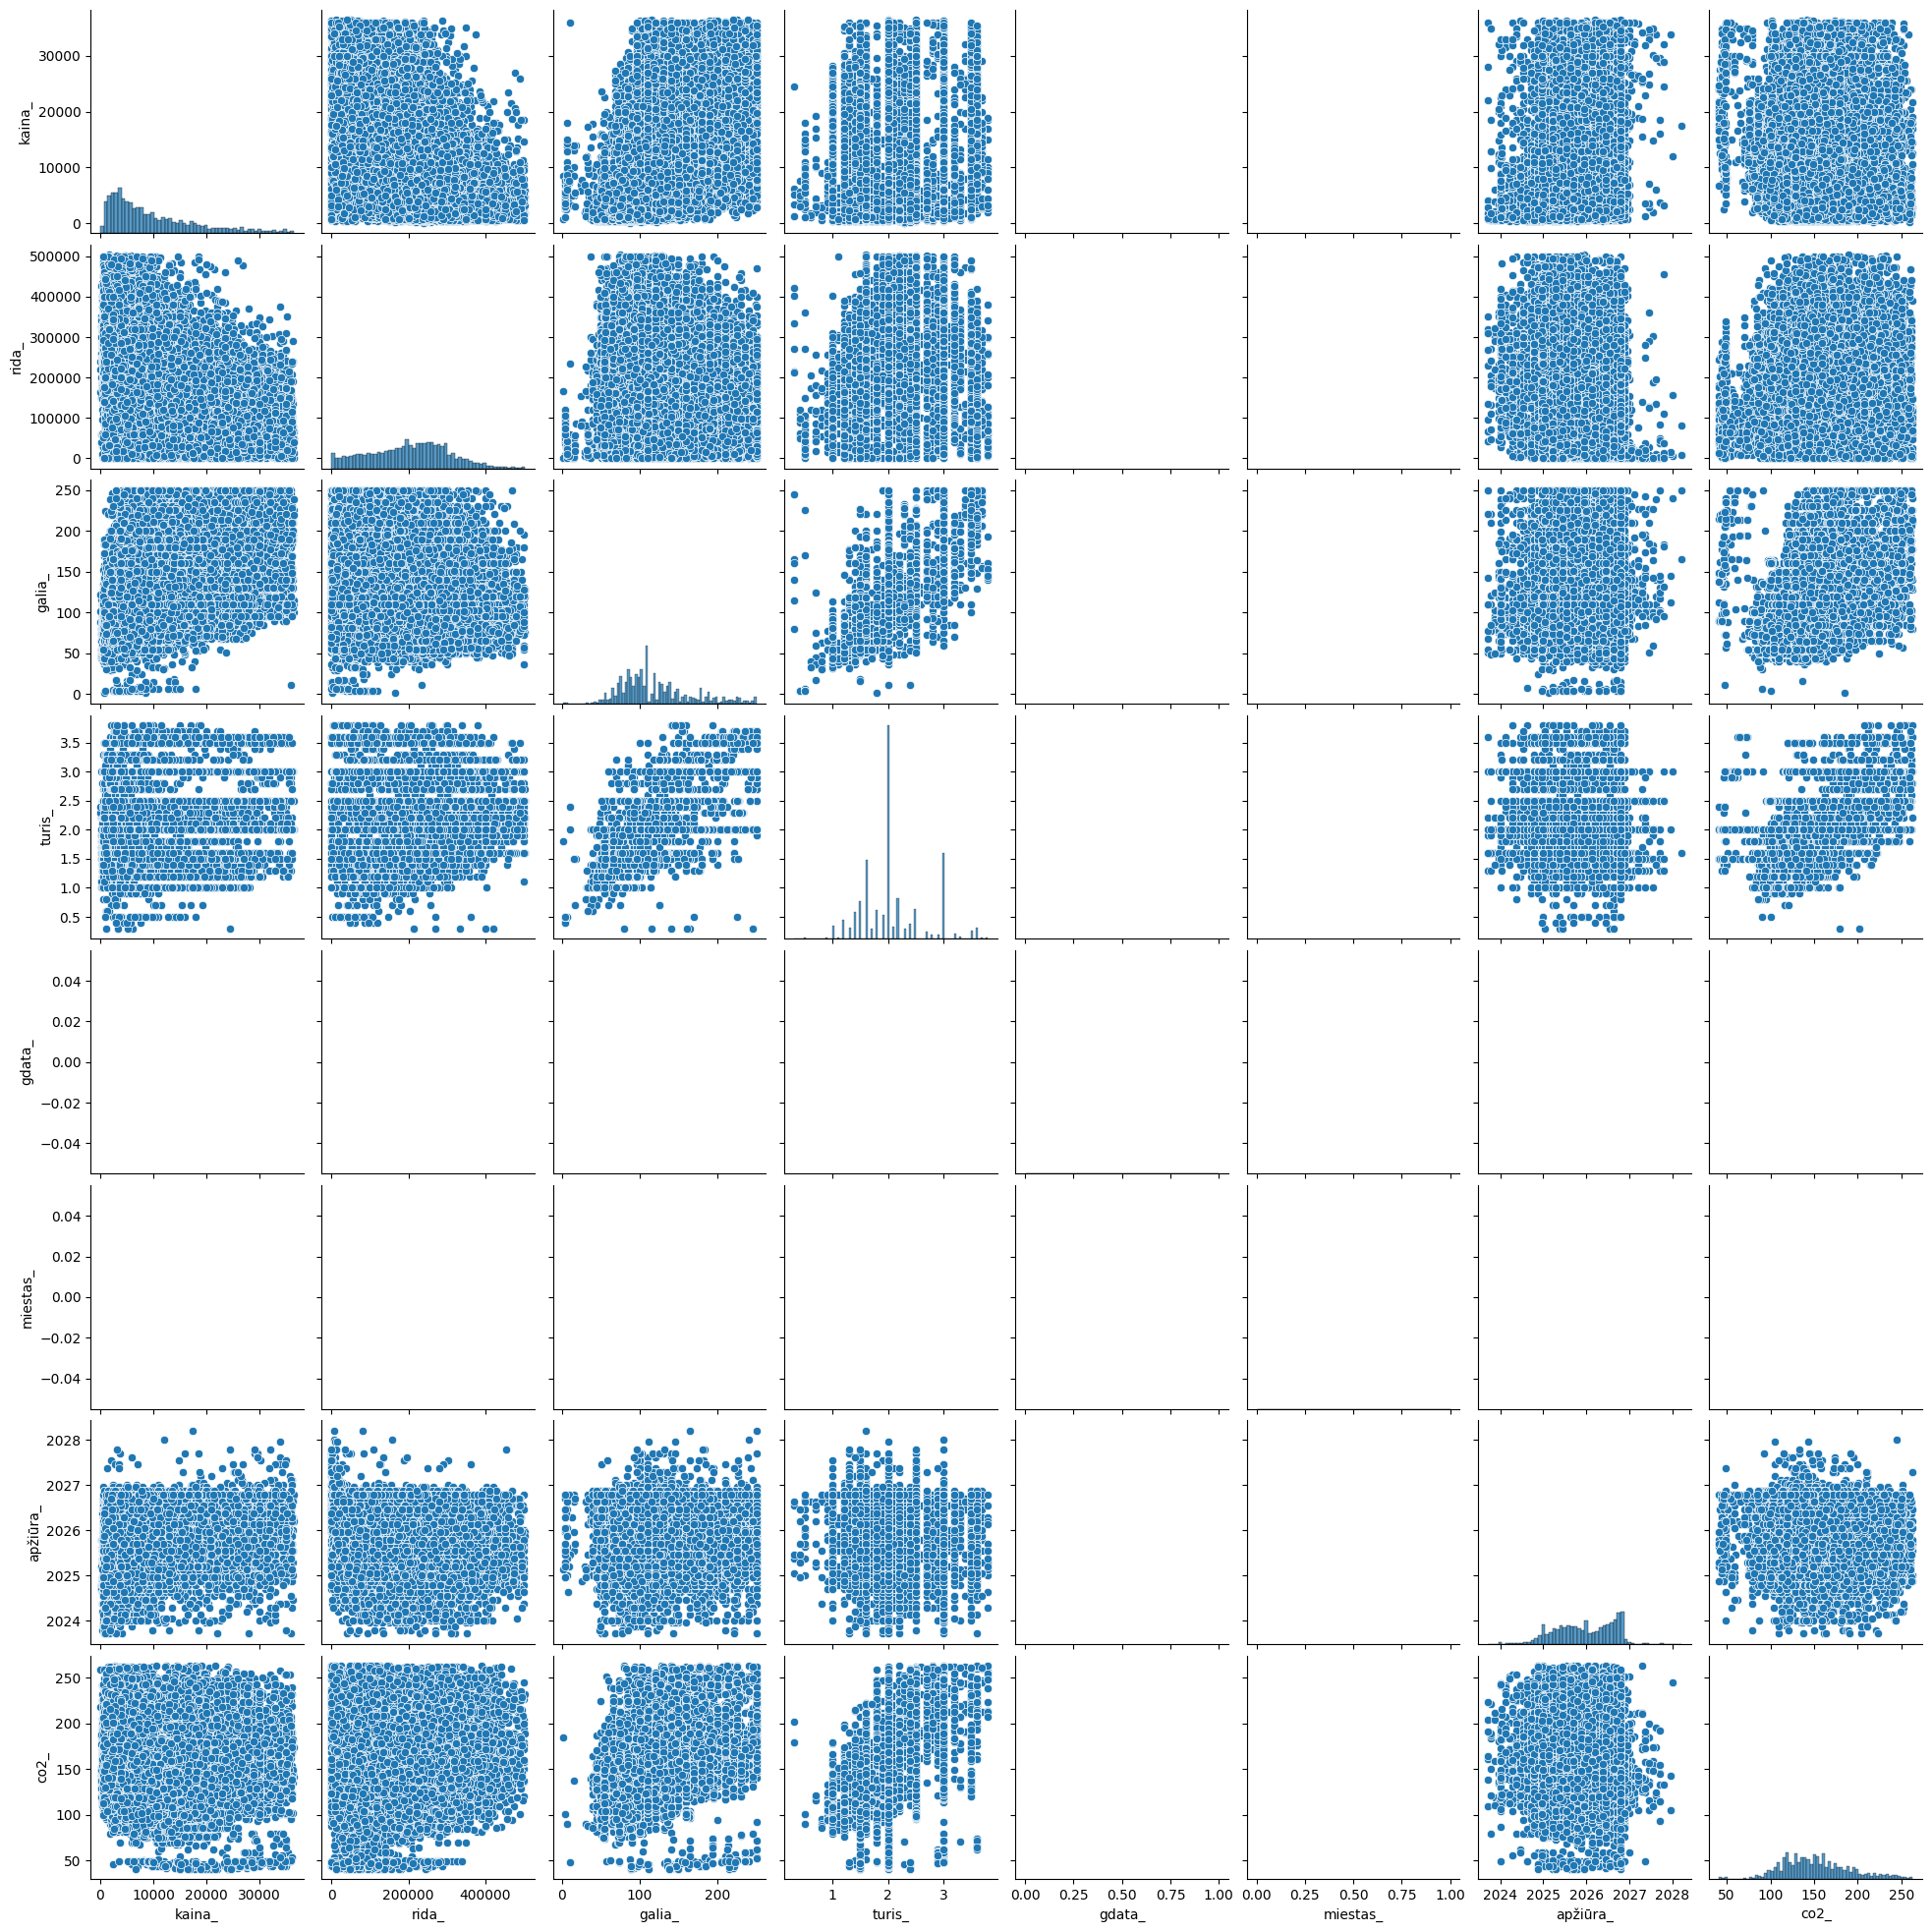

In [ ]:
print("Generuojamas sns.pairplot(data=df1). EliteBook apie 30s.")
sns.pairplot(data=df1) # Reikia išmesti ne skaičius.

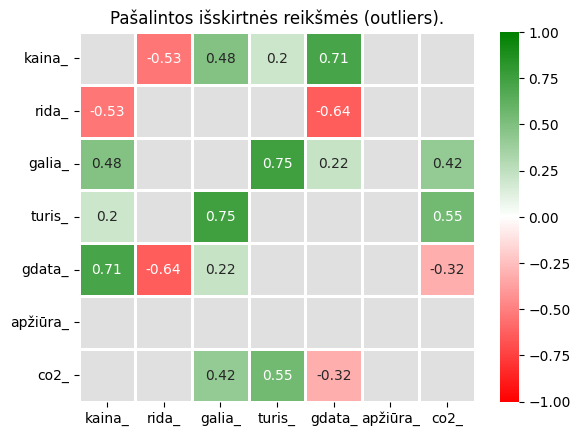

In [82]:
from matplotlib.colors import LinearSegmentedColormap

# Sukuriame pasirinktą spalvų schemą
colors = ["red", "white", "green"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
custom_cmap.set_bad(color="#E0E0E0")  # Pilka spalva `NaN` reikšmėms

cr_matrix = df1.corr(numeric_only=True,method='pearson')

# Nustatome modulio ribą
threshold = 0.2

# Panaikiname koreliacijas, kurių modulis mažesnis už ribą
cr_matrix = cr_matrix.where(abs(cr_matrix)>threshold)

# Panaikiname įstrižainės reikšmes
np.fill_diagonal(cr_matrix.values,np.nan)

# Nubrėžiame heatmap su savo spalvų schema
sns.heatmap(data=cr_matrix,cmap=custom_cmap,annot=True,cbar=True,linecolor='white',linewidths='2',vmin=-1,vmax=1)

plt.title("Pašalintos išskirtnės reikšmės (outliers).")
plt.show()

In [83]:
df1.columns

Index(['id', 'gamintojas', 'kaina_', 'rida_', 'galia_', 'turis_', 'gdata_',
       'miestas_', 'apžiūra_', 'co2_'],
      dtype='object')

In [84]:
df1.head(5)

,id,gamintojas,kaina_,rida_,galia_,turis_,gdata_,miestas_,apžiūra_,co2_
0,10481001,Iveco,11220.0,250000.0,93.0,2.3,2015.0,kaunas,NaN,NaN
1,10538831,Mercedes-Benz,9600.0,200000.0,NaN,3.0,NaN,kuršėnai,NaN,NaN
2,10668165,Infiniti,9999.0,300000.0,235.0,3.7,2010.0,vilnius,2026.0,NaN
3,11068939,Peugeot,1700.0,279500.0,66.0,2.0,2007.0,alytus,NaN,152.0
4,11317191,Nissan,13700.0,100000.0,127.0,2.5,2017.0,automatinė,2025.0,NaN


In [85]:
# Pašalinami įrašai, kuriems trūksta duomenų:

# Pasirenkame tik tas eilutes, kuriose nėra NaN reikšmių stulpeliuose
df2 = df1[['kaina_','galia_','turis_','apžiūra_','co2_']].dropna()

# Dabar į df3 įtraukiame stulpelius d ir e iš df2, nepriklausomai nuo NaN
df2 = df2.merge(df1[['id','gamintojas','gdata_','miestas_']],left_index=True,right_index=True)

print("len(df1) =",len(df1))
print(df1.head(5))
print("len(df2) =",len(df2))
print(df2.head(5))

len(df1) = 35913
         id     gamintojas   kaina_     rida_  galia_  turis_  gdata_  \
0  10481001          Iveco  11220.0  250000.0    93.0     2.3  2015.0   
1  10538831  Mercedes-Benz   9600.0  200000.0     NaN     3.0     NaN   
2  10668165       Infiniti   9999.0  300000.0   235.0     3.7  2010.0   
3  11068939        Peugeot   1700.0  279500.0    66.0     2.0  2007.0   
4  11317191         Nissan  13700.0  100000.0   127.0     2.5  2017.0   

     miestas_  apžiūra_   co2_  
0      kaunas       NaN    NaN  
1    kuršėnai       NaN    NaN  
2     vilnius    2026.0    NaN  
3      alytus       NaN  152.0  
4  automatinė    2025.0    NaN  
len(df2) = 14642
     kaina_  galia_  turis_  apžiūra_   co2_        id     gamintojas  gdata_  \
19  11490.0    75.0     1.3    2026.0  116.0  15041529          Honda  2015.0   
28  27700.0   190.0     3.0    2026.0  179.0  16603115  Mercedes-Benz  2016.0   
29  27000.0   140.0     2.0    2024.0  154.0  16713369          Skoda  2019.0   
48   

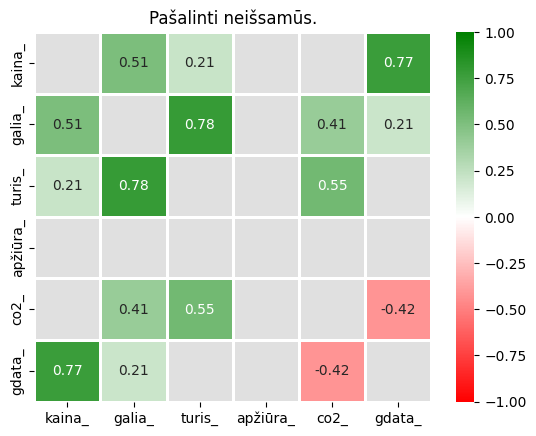

In [86]:
from matplotlib.colors import LinearSegmentedColormap

# Sukuriame pasirinktą spalvų schemą
colors = ["red", "white", "green"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
custom_cmap.set_bad(color="#E0E0E0")  # Pilka spalva `NaN` reikšmėms

cr_matrix = df2.corr(numeric_only=True,method='pearson')

# Nustatome modulio ribą
threshold = 0.2

# Panaikiname koreliacijas, kurių modulis mažesnis už ribą
cr_matrix = cr_matrix.where(abs(cr_matrix)>threshold)

# Panaikiname įstrižainės reikšmes
np.fill_diagonal(cr_matrix.values,np.nan)

# Nubrėžiame heatmap su savo spalvų schema
sns.heatmap(data=cr_matrix,cmap=custom_cmap,annot=True,cbar=True,linecolor='white',linewidths='2',vmin=-1,vmax=1)

plt.title("Pašalinti neišsamūs.")
plt.show()